# CHAPTER 7: Ensemble Learning and Random Forest

- If you aggregate the predictions of a group of predictors ( such as classifiers or regressors), you will often get better predictions than with best individual predictor.
- A group of predictors is called an **ensemble**, thus, this technique is called **Ensemble Learning**, and an Ensemble Learning algorithm is called an **Ensemble method**
- For example, you can train a group of Decision Tree classifiers, each on a different
random subset of the training set. To make predictions, you just obtain the predictions
of all individual trees, then predict the class that gets the most votes
 - Such an ensemble of Decision Trees is called a **Random Forest**,
and despite its simplicity, this is one of the most powerful Machine Learning algorithms
available today.

**You will often use Ensemble methods near the end of a project, once you have already built a few good predictors, to combine them into an even better predictor. In fact, the winning solutions in ML competitions often involve several ensemble methods.**

## 7.1 Voting Classifiers

- Suppose you have trained few classifiers, each one achieving about 80% accuracy.
- A very simple way to create an even better classifier is to aggregate the predictions of each classifier and predict the class that gets the most votes.
- This majority-vote classifier is called a **hard voting** classifier

**Ensemble methods work best when the predictors are as <span style='color:red'>independent</span>
from one another as possible. One way to get diverse classifiers
is to train them using very different algorithms. This increases the
chance that they will make very different types of errors, improving
the ensemble’s accuracy.**

- The following code creates and trains a voting classifier in Scikit-Learn, composed of three diverse classifiers

In [4]:
# prepare the dataset

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X,y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma='scale', random_state=42)

voting_clf = VotingClassifier(
    estimators = [('lr',log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

- Lets look at each individual classifier's accuracy on the test set
- And, voting classifier accuracy on the test set

In [6]:
from sklearn.metrics import accuracy_score

for clf in (log_clf,rnd_clf,svm_clf,voting_clf):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_pred, y_test))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


**VotingClassifier accuracy is higher than the individual classifiers' accuracy.**

Note: 
- If all classifiers are able to estimate class probabilities (i.e they have a predict_proba() method), then you can tell Scikit-Learn to predict the class with the highest class probabilitiy, averaged for all the individual classfiers.
- It often achieves higher performance than hard voting because it gives more
weight to highly confident votes.
- All you need to do is replace **voting="hard"** with
**voting="soft"** and ensure that all classifiers can estimate class probabilities.

- This is not the case of the SVC class by default, so you neeed to set its probabilitiy hyperparameter to True (this will make the SVC class use cross-validation to estimate class probabilities, slowing down training, and it will ad a predict_proba() method)

Lets modify the code to **soft voting**, the voting classifier will achieve more accuracy.

Note: SVM default kernel is RBF. (radial basis function)

In [7]:
svm_clf_proba = SVC(gamma='scale', random_state=42, probability=True)

voting_clf_soft = VotingClassifier(
    estimators = [('lr',log_clf), ('rf', rnd_clf), ('svc', svm_clf_proba)],
    voting='soft')

voting_clf_soft.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

In [8]:
y_pred = voting_clf_soft.predict(X_test)
accuracy_score(y_pred, y_test)

0.92

- **Soft voting** accuracy is higher than **Hard Voting**.
- If each classifier has predict_proba() method, using soft voting is better.

## 7.2 Bagging and Pasting

- One way to get a diverse set of classifiers is to use very different training algorithms, as just discussed.
- **Another approach** is to use the same training algorithm for every predictor, but to train them on different random subsets of the training set.

- **Bagging:** when sampling is performed with replacement (putting back the selected instance to the pool)
- **Pasting:** when sampling is performed without replacement (if you select the instance for a predictor, anoter predictor cannot choose the same instance)

- In other words, both bagging and pasting allow training instances to be sampled several
times across multiple predictors, but only bagging allows training instances to be
sampled several times for the same predictor.

- Once all predictors are trained, the ensemble can make a prediction for a new
instance by simply aggregating the predictions of all predictors. The aggregation
function is typically the statistical mode (i.e., the most frequent prediction, just like a
hard voting classifier) for classification, or the average for regression

- Each individual predictor has a **higher bias** than if it were trained on the original training set, but aggregation reduces both bias and variance.
- Generally, the net result is that the ensemble has a **similar bias** but a **lower variance** than a single predictor trained on the original training set.

### 7.2.1 Bagging and Pasting in Scikit-Learn

- The following code trains an ensemble of 500 decision tree classifiers, each trained on 100 training instances randomly sampled from the training set with replacement (bagging)
- the n_jobs parameter tells Scikit-Learn the number of CPU cores to use for training and predictions. (-1 tells to use all available cores)
- max_samples: the number of samples to draw from X to train each base estimator.

In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)

bag_clf.fit(X_train,y_train)
y_pred = bag_clf.predict(X_test)

- The BaggingClassifier automatically performs **soft voting** instead of **hard voting** if the base classifier can estimate class probabilities (i.e., if it has a predict_proba() method), which is the case with Decision Trees classifiers

In [10]:
print('BaggingClassifier accuracy:', accuracy_score(y_test, y_pred))

BaggingClassifier accuracy: 0.904


In [11]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print('A DecisionTree accuracy:', accuracy_score(y_test, y_pred_tree))

A DecisionTree accuracy: 0.856


Next codes for plotting the charts

In [12]:
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt
import numpy as np
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s,x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
        
    # plot original X values
    plt.plot(X[:,0][y==0], X[:,1][y==0], 'yo', alpha=alpha)
    plt.plot(X[:,0][y==1], X[:,1][y==1], 'bs', alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r'$x_1$', fontsize=18)
    plt.ylabel(r'$x_2$', fontsize=18, rotation=0)

Text(0, 0.5, '')

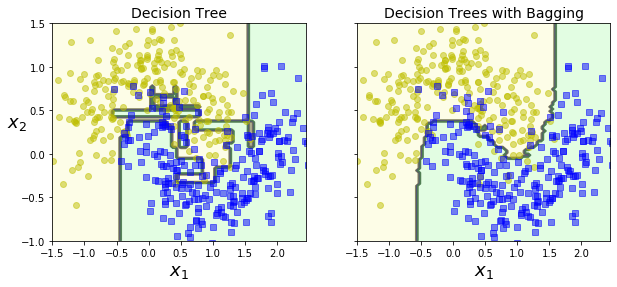

In [13]:
#note: sharex or sharey: Controls sharing of properties among x (sharex) or y (sharey) axes:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plt.title('Decision Tree', fontsize=14)
plot_decision_boundary(tree_clf,X,y)

plt.sca(axes[1])
plt.title('Decision Trees with Bagging', fontsize=14)
plot_decision_boundary(bag_clf, X,y)
plt.ylabel("")

- This figure compares the decision boundary of a single decision tree with the decision boundary of a bagging ensemble of 500 trees.
- The ensemble's predictions will likely generalize much better than the single decision tree's predictions.
- The ensemble has a **comparable bias but a smaller variance** (it makes roughly the same number of errors on the training set, but the decision boundary is less irregular.)

### 7.2.2 Out-of-Bag Evaluation

- With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all.
- The training instances that are not sampled are called **out-of-bag (oob)** instances. Note that they are not the same for all predictors.
- Since a predictor never sees the oob instances during training, it can be evaluated on these instances, without the need for a separate validation set.
- You can evaluate the ensemble itself by averaging out the oob evaluations of each predictor.

- In Scikit-Learn, set **oob_score=True** when creating a **BaggingClassifier** to request an automatic oob evaluation after training.

In [14]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

- According to this oob evaluation, this BaggingClassifier is likely to achieve about 90.1% accuracy on the test set. 
- Lets try, you will see results are close enough!!!

In [15]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.912

- The oob decision function for each training instance is also available. 
- In this case (since the base estimator (DecisionTreeClassifier) has a predict_proba() method) the decision function returns the class probabilities for each training instance.

Note: Decision function computed with out-of-bag estimate on the training set. If n_estimators is small it might be possible that a data point (an instance) was never left out during the bootstrap. (for example, may be 150.instance were selected for training all 10 estimators. And you have 10 estimators in total. n_estimators=10) In this case, oob_decision_function_ might contain NaN for 150.instance. This attribute exists only when **oob_score** is True.
But if you have a lot of estimators (lets say n_estimators=500), it is more likely to have at least one estimator that does not use 150.instance. So, decision function for 150.instance can be obtained from that estimator.

Ex: The oob evaluation estimates that the first training instance has 68.25% probability of belonging to the positive class

In [16]:
# Decision function computed with out-of-bag estimate on the training set.
#print the first 5
bag_clf.oob_decision_function_[0:5]

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ]])

## 7.3 Random Patches and Random Subspaces

- The **BaggingClassifier** class supports sampling the features as well.
- This is controlled by two hyperparameters: **max_features**, **bootstrap_features**. (They work the same way as max_samples, and bootstrap. But for the feature sampling instead of instance sampling)
- Thus, each predictor will be trained on a random subset of the input features.
- This is particularly useful when you are dealing with **high-dimensional inputs** (such as images)

- **Random Patches:** sampling both training instances and features
- **Random Subspaces:** sampling only training features with bootstrap_features=True and/or max_features smaller than 1.0. (keep all training instances with bootstrap=False, max_samples=1.0). (all instances are used in each estimator, there is no sampling for instances)

**Sampling features results in even more predictor diversity(higher bias),so trading a bit more bias for a lower variance.**

## 7.4 Random Forests

- Random Forests is an ensemble of Decision Trees, generally trained via the bagging method (or sometimes pasting), typically with max_samples set to the size of the training set.
- Instead of building a BaggingClassifier and passing it a DecisionTreeClassifier, you can instead use the **RandomForestClassifier** class, which is more convenient and optimized for Decision Trees (similarly, there is a **RandomForestRegressor** class for regression tasks)

The following code trains a RandomForestClassifier with 500 trees (each limited to maximum to 16 leaf nodes), using all available CPU cores.
- A RandomForestClassifier has all the hyperparameters of a DecisionTreeClassifier (to control how trees are grown), plus all the hyperparameters of a BaggingClassifier to control the ensemble itself.

In [17]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

- The Random Forest algorithm introduces **extra randomness** when growing trees;
 - instead of searching for the very best feature when splitting a node,
 - it searches for the best feature among a random subset of features.
 
**This results in a greater tree diversity, which trades higher bias for a lower variance, enerally yielding an overall better model.**

- The following BaggingClassifier is roughly quivalent to the previous RandomForestClassifier.
- splitter is especially set to random since RandomForestClassifier searches for the best feature among a **random subset of features**

In [18]:

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter='random', max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, random_state=42)

bag_clf.fit(X_train,y_train)
y_pred = bag_clf.predict(X_test)

In [19]:
# to compare predictions of RandomForestClassifier and similarly designed BaggingClassifier
# almost identical predictions
np.sum(y_pred_rf == y_pred) / len(y_pred)

0.976

### 7.4.1 Extra-Trees
 
- When you are growing a tree in a Random Forest, at each node only a random subset
of the features is considered for splitting (as discussed earlier).
- It is possible to make
trees even more random by also using random thresholds for each feature rather than
searching for the best possible thresholds (like regular Decision Trees do).
- A forest of such extremely random trees is simply called an **Extremely Randomized**
Trees ensemble12 (or **Extra-Trees** for short).
- Once again, this trades more bias for a
lower variance. It also makes Extra-Trees much faster to train than regular Random
Forests since finding the best possible threshold for each feature at every node is one
of the most time-consuming tasks of growing a tree.

Scikit-Learn >>> ExtraTreesClassifier, ExtraTreesRegressor

### 7.4.2 Feature Importance

- Yet another great quality of Random Forests is that they make it easy to measure the
relative importance of each feature.
- Scikit-Learn measures a feature’s importance by
looking at how much the tree nodes that use that feature reduce impurity on average
(across all trees in the forest).
- More precisely, it is a weighted average, where each
node’s weight is equal to the number of training samples that are associated with it

In [20]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)

# iris data contains 4 features
rnd_clf.fit(iris['data'], iris['target'])

for name,score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name,score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [21]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

Example: The most important features in MNIST dataset

In [22]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [23]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [24]:
import matplotlib as mpl
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

[Text(1, 0, 'Not important'), Text(1, 0, 'Very important')]

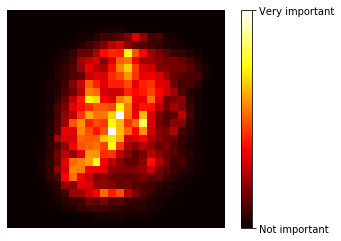

In [25]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

## 7.5 Boosting


- Boosting (originally called hypothesis boosting) refers to any **ensemble method** that can combine several weak learners into a strong learner.
- The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor.

## 7.5.1 AdaBoost (Adaptive Boosting)

- One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfitted.
- This results in new predictors focusing more and more on the hard cases (wrong predictions)

**How does it work?:** 

- To build an AdaBoost classifier, a first base classifier (such as a Decision Tree) is trained and used to make predictions on the training set.
- The relative weight of misclassified training instances is then increased.
- A second classifier is trained using the updated weights and again it makes predictions on the training set, weights are updated, and so on.

**Scikit-Learn Example**

- Scikit-Learn uses a multiclass version of AdaBoost called **SAMME (which stands for Stagewise Additive Modeling using a Multiclass Exponential loss function)**
 - When there are just two classes, SAMME is equivalent to AdaBoost.
- Moreover, if the predictors can estimate class probabilities (i.e.i if they have a **predict_proba()** method), Scikit-Learn can use a variant of SAMME called **SAMME.R** (the R stands for 'Real'), which relies on class probabilities rather than predictions and **generally performs better**

- The following code trains an AdaBoost classifier based on 200 **Decision Stumps** using Scikit-Learn's **AdaBoostClassifier** (there is also **AdaBoostRegressor** for regression)
- **A Decision Stump** is a Decision Tree with max_depth=1 --in other words, a tree composed of a single decision node plus two leaf nodes.
- **This is the default base estimator for the AdaBoostClassifier** class.

In [26]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME.R', learning_rate=0.5, random_state=42)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

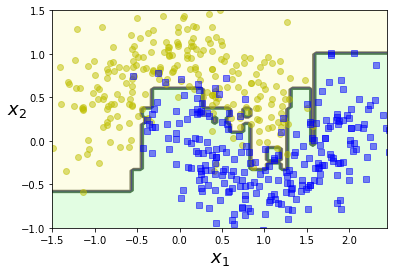

In [28]:
plot_decision_boundary(ada_clf,X,y)

**NOTE**: If your AdaBoost ensemble is overfitting the training set, you can try reducing the number of estimators or more strongly regularizing the base estimator.

**EXAMPLE**
- Below example is just to show how decision boundaries are changing in each iteration of AdaBoost.
- It will be implemented manually instead of Scikit-Learn.

Text(-0.3, 0.9, '5')

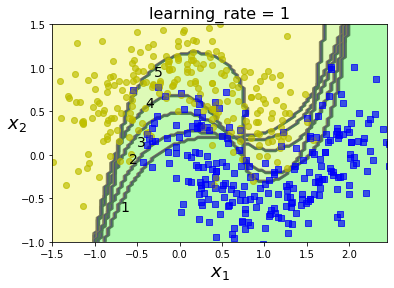

In [33]:
m = len(X_train)
learning_rate = 1

#initial weights are equal for all instances. Lets assign 1.
sample_weights = np.ones(m)

for i in range(5):
    svm_clf=SVC(kernel='rbf',C=0.05, gamma='scale',random_state=42)

    #there is sample_weight parameter of SVC.
    svm_clf.fit(X_train, y_train, sample_weight=sample_weights)

    y_pred = svm_clf.predict(X_train)

    # update the sample weights that are not classified correctly
    sample_weights[y_pred != y_train] = sample_weights[y_pred != y_train] * (1+learning_rate)
    plot_decision_boundary(svm_clf, X,y, alpha=0.2)
    
plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
plt.text(-0.7, -0.65, "1", fontsize=14)
plt.text(-0.6, -0.10, "2", fontsize=14)
plt.text(-0.5,  0.10, "3", fontsize=14)
plt.text(-0.4,  0.55, "4", fontsize=14)
plt.text(-0.3,  0.90, "5", fontsize=14)

- Lets do the same with different learning rate

Text(0.5, 1.0, 'learning_rate = 0.5')

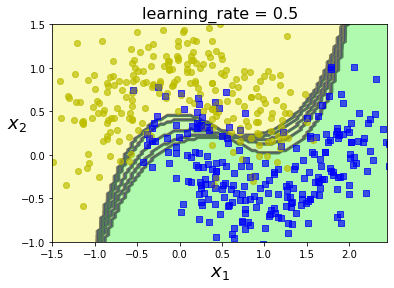

In [35]:
m = len(X_train)
learning_rate = 0.5

#initial weights are equal for all instances. Lets assign 1.
sample_weights = np.ones(m)

for i in range(5):
    svm_clf=SVC(kernel='rbf',C=0.05, gamma='scale',random_state=42)

    #there is sample_weight parameter of SVC.
    svm_clf.fit(X_train, y_train, sample_weight=sample_weights)

    y_pred = svm_clf.predict(X_train)

    # update the sample weights that are not classified correctly
    sample_weights[y_pred != y_train] = sample_weights[y_pred != y_train] * (1+learning_rate)
    plot_decision_boundary(svm_clf, X,y, alpha=0.2)
    
plt.title("learning_rate = {}".format(learning_rate), fontsize=16)

## 7.5.2 Gradient Boosting

- Just like AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor.
- However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the **residual errors** made by precious predictor.

**Example**
- A simple regression example using Decision Trees as the base predictors.
- This is called **Gradient Tree Boosting**, or **Gradient Boosted Regression Trees (GBRT)**.
- First, lets fit a DecisionTreeRegressor to the training set.

In [46]:
np.random.seed(42)
X = np.random.rand(100,1) - 0.5
y = 3*X[:,0]**2 + 0.05 * np.random.randn(100)

In [48]:
X.shape, y.shape

((100, 1), (100,))

In [49]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X,y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

- Now train a second DecisionTreeRegressor on the residual errors made by the first predictor

In [50]:
# Find the residuals
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

- Then we train a third regressor on the residual errors made by the second predictor.

In [51]:
#find the residuals
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

- Now we have an esnemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees:

In [52]:
X_new = np.array([[0.8]])

In [54]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3)) 
y_pred

array([0.75026781])

**Show previous Example - with chart**

In [69]:
def plot_predictions(regressors, X, y, axes, label=None, style='r-', data_style='b.', data_label=None):
    #create new x values
    x1 = np.linspace(axes[0], axes[1],500)
    #calculate the predictions
    y_pred = sum(regressor.predict(x1.reshape(-1,1)) for regressor in regressors)
    
    plt.plot(X[:,0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    
    if label or data_label:
        plt.legend(loc='upper center', fontsize=16)
    plt.axis(axes)

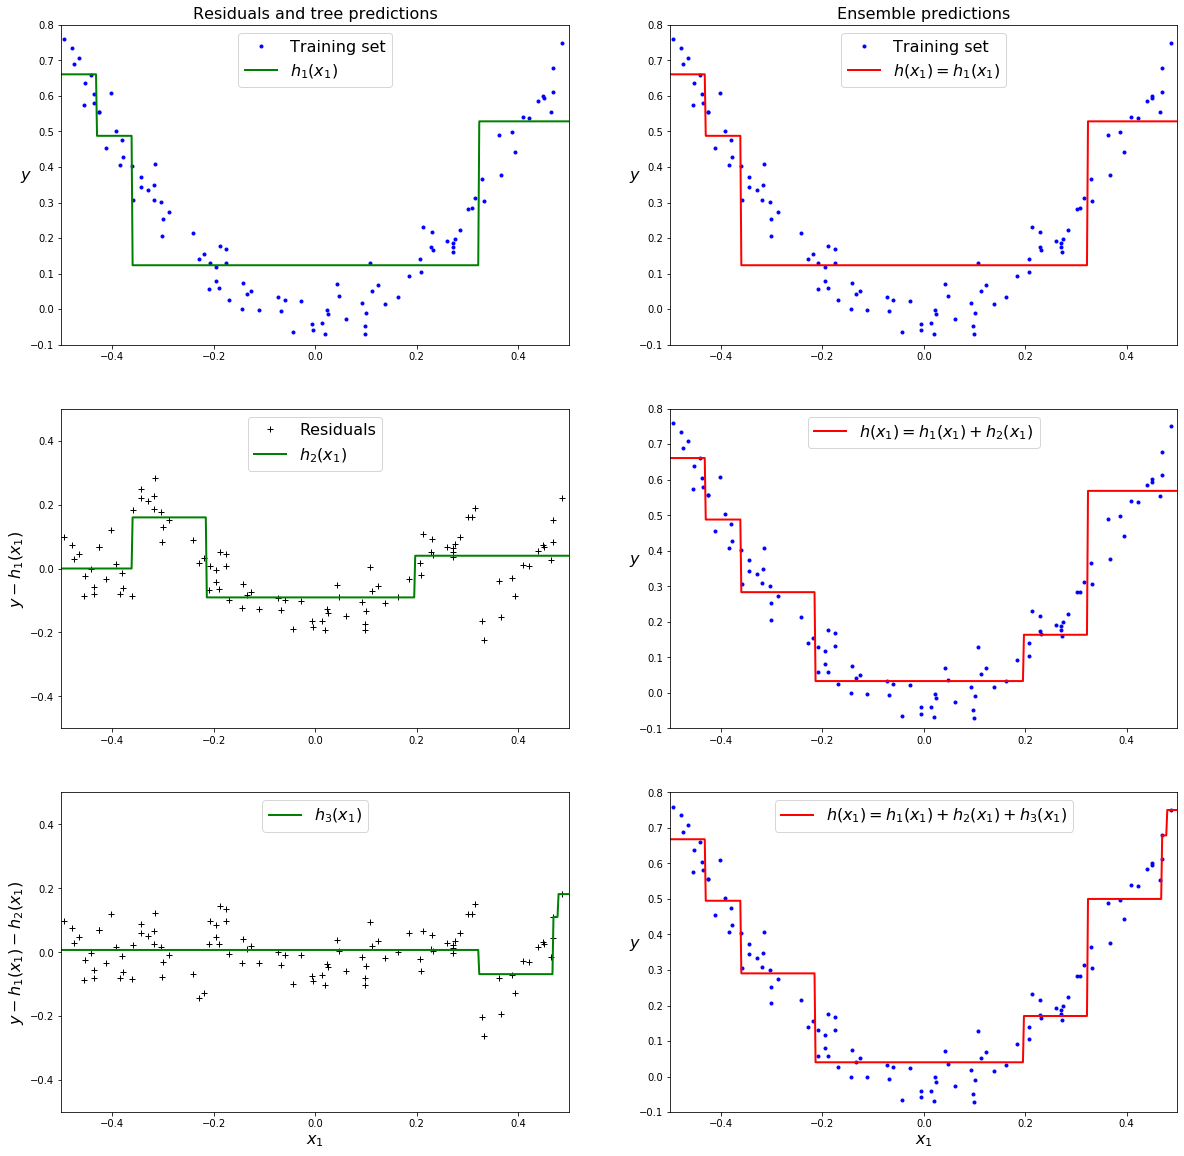

In [70]:
plt.figure(figsize=(20,20))

# Create a figure 3x2, this is the 1st element
plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label='$h_1(x_1)$', style='g-', data_label='Training set')
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

# this is second figure
plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

- Left column represents the predictions of three trees in the left column, and the ensemble's predictions in the right column.
- In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree's predictions.
- In the second row, a new tree is trained on the residual errors of the first tree. On the right you can see that the ensemble's predictions are equal to the sum of the predictions of the first two trees. 
- Similarly, in the third row another tree is trained on the residual errors of the second tree. You can see that the ensemble's predictions gradually get better as trees are added to the ensemble. 

### **Scikit-Learn GBRT (Gradient Boosting Regression Trees)**

- A simpler way to train GBRT ensembles is to use Scikit-Learn's GradientBoostingRegressor class. ,
- Much like the RandomForestRegressor class, it has hyperparameters to control the growth of Decision Trees (max_depth, min_samples_leaf etc.), as well as hyperparameters to control the ensemble training, such as the number of trees (n_estimators)

In [71]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X,y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [76]:
#lets create another with slow learning. (low learning rate)

gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X,y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

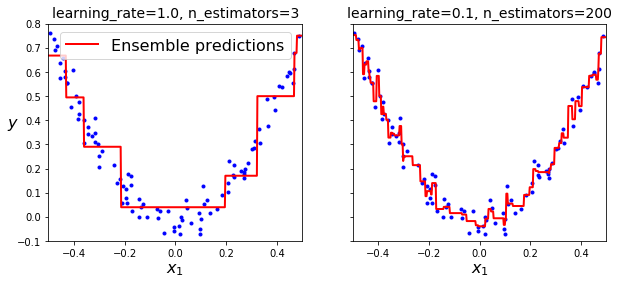

In [77]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)


plt.show()

- The **learning rate** hyperparameter scales the contribution of each tree.
- If you set it to a low value, such as 0.1, you will need more trees in the ensemble to fit the training set, but **<span style='color:green'>predictions will usually generalize better.</span>** 
- This is a regularization technique called **shrinkage**.
- In above figure, left GBRT does not have enough trees to fit the training set, while the right one has too many trees and overfits the training set.

### Gradient Boosting with Early Stopping

**How to find the optimal number of trees?**

- In order to find the optimal number of trees, you can use **early stopping**.
- A simple way to implement this is to use the **staged_predict()** method: it returns an iterator over the predictions made by the ensemble at each stage of the training (with one tree, two trees, etc.)
- The following code trains a GBRT ensemble with 120 trees, then measures the validation error at each stage of training to find the optimal number of trees, and finally trains another GBRT ensemble using the optimal number of trees. 


<span style='color:red'>**Note**: It is not stopping the training when it finds the best number of estimators, but it continues until the end. After the completion, it looks for the best number of estimators. So it is not actually early_stopping</span>
-  Logic: Training a large number of trees first and then looking back to find the optimal number

In [81]:
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X,y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train,y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]

# get the index of the minimum error, add 1 to find number of estimators (since index starts from 0)
best_n_estimators = np.argmin(errors)+1

# train gbrt with optimal n_estimator value
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=56,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [84]:
min_error = np.min(errors)
min_error

0.002712853325235463

In [83]:
best_n_estimators

56

In [95]:
len(errors)

120

Text(0, 0.5, '$y$')

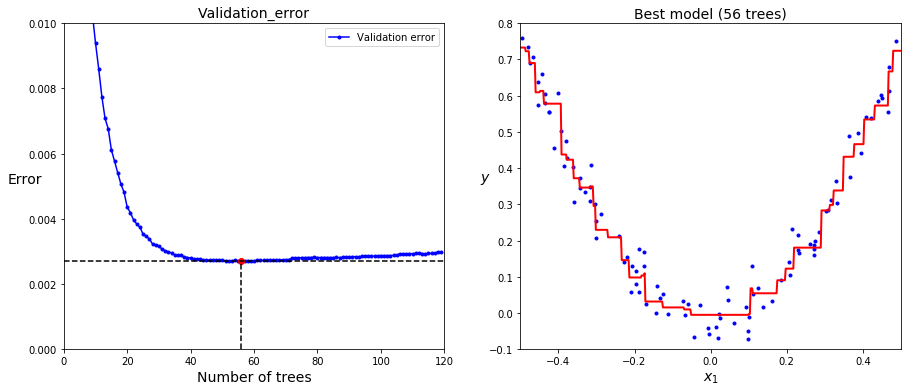

In [130]:
plt.figure(figsize=(15,6))

#first chart
plt.subplot(121)
plt.plot(errors, 'b.-', label='Validation error')
plt.axis([0, 120, 0, 0.01])
plt.plot(best_n_estimators, min_error, 'ro')

#plot the horizontal dashed line. min_error
#provide 2 points 0,min_error and 120,min_error x,y coordinates
plt.plot([0,120],[min_error,min_error], 'k--')

#plot the vertical dashed line. best_n_estimators
plt.plot([best_n_estimators,best_n_estimators],[0,min_error], 'k--')

plt.title('Validation_error', fontsize=14)
plt.legend(loc='upper right')
plt.ylabel('Error', fontsize=14, rotation=0)
plt.xlabel('Number of trees', fontsize=14)


# second chart
plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title('Best model ({} trees)'.format(best_n_estimators), fontsize=14)
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$y$', fontsize=14, rotation=0)

**Lets do real early stopping.** 
- So the training will stop when adding new trees no longer decrease the validation error for 5 iterations in a row.

- In this example, we will implement early stopping by actually stopping training early(instead of training a large number of trees first and then looking back to find the optimal number)
- You can do so by setting **warm_start=True**, which makes Scikit-Learn keep existing trees when the fit() method is called, allowing incremental training. 

In [172]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float('inf')
#number of iterations that error goes up
error_going_up = 0

for n_estimators in range(1,120):
    gbrt.n_estimators=n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    
    val_error = mean_squared_error(y_val, y_pred)
    
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up=0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break # early stopping

In [173]:
gbrt.n_estimators

61

In [174]:
# you will see this is same as early solution
# earlier solution results
min_error, best_n_estimators

(0.002712853325235463, 56)

In [175]:
print('Best number of estimators:', gbrt.n_estimators-5)

Best number of estimators: 56


In [176]:
print('Minimum validation MSE:', min_val_error)

Minimum validation MSE: 0.002712853325235463


- The GradientBoostingRegressor class also supports a subsample hyperparameter, which specifies the fraction of training instances to be used for training each tree.
- For example, if **subsample=0.25**, then each tree is trained on 25% of the training instances, selected randomly.
- As you can probably guess by now, this trades a higher bias for a lower variance.
- It also speeds up training considerably
- This technique is called **Stochastic Gradient Boosting.**

### **Using XGBoost**

- It is worth noting that an optimized implementation of Gradient Boosting is available in the popular python library **XGBoost** which stands for Extreme Gradient Boosting.
- It aims at being extremely fast, scalable and portable.
- <span style='color:green'> **In fact, XGBoost is often an important component of the winning entries in ML competitions.(Kaggle)** </span>
- XGBoost's API is quite similar to Scikit-Learn's.

In [177]:
import xgboost

In [178]:
np.random.seed(42)

In [179]:
xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train,y_train)
y_pred = xgb_reg.predict(X_val)

val_error = mean_squared_error(y_val, y_pred)
print('Validation MSE:', val_error)

Validation MSE: 0.004000408205406276


- XGBoost also offers several nice features, such as automatically taking care of early stopping
- If you have a valdiation set, you can use early stopping to dinf the optimal number of boosting rounds. Early stopping requires at least one set in **evals.**. If there is more than one, it will use the last. In our example, we have 1 set (X_val, y_val)
- Validation error needs to decrease (improve) at least every early_stopping_rounds (in our example, it is 2) to continue training.
    - the logic similar with the ScikitLearn's n_iter_no_change. (terminate the training when validation score is not improving in all of the previous n_iter_no_change number of iterations.

In [180]:
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)

y_pred = xgb_reg.predict(X_val)

val_error = mean_squared_error(y_val, y_pred)
print('Validation MSE:', val_error)

[0]	validation_0-rmse:0.22834
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
[9]	validation_0-rmse:0.05211
Validation MSE: 0.002630868681577655


- Validation error increased in last 2 iterations, so that the training is stopped.

In [181]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train)

41.8 ms ± 1.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [182]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

24.1 ms ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 7.6 Stacking

- The last Ensemble method we will discuss in this chapter is called stacking (short for stacked generalization)
- It is based on a simple idea: instead of using trivial functions (such as hard voting) to aggregate the predictions of all predictors in an ensemble, we train a model to perform this aggregation.

**Note**
- <span style='color:red'>Unfortunately, Scikit-Learn does not support stacking directly, but it is not too hard to roll out your own implementation.</span>
- Alternatively, you can use an open source implementation such as brew (available at https://github.com/viisar/brew).

# Exercises

**1.**  Load the MNIST data (introduced in Chapter 3), and split it into a training set, a
validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation,
and 10,000 for testing). Then train various classifiers, such as a Random
Forest classifier, an Extra-Trees classifier, and an SVM. Next, try to combine
them into an ensemble that outperforms them all on the validation set, using a
soft or hard voting classifier. Once you have found one, try it on the test set. How
much better does it perform compared to the individual classifiers?

**2.** Run the individual classifiers from the previous exercise to make predictions on
the validation set, and create a new training set with the resulting predictions:
each training instance is a vector containing the set of predictions from all your
classifiers for an image, and the target is the image’s class. Train a classifier on
this new training set. Congratulations, you have just trained a blender, and
together with the classifiers they form a stacking ensemble! Now let’s evaluate the
ensemble on the test set. For each image in the test set, make predictions with all
your classifiers, then feed the predictions to the blender to get the ensemble’s predictions.
How does it compare to the voting classifier you trained earlier?

**Exercise 1 - Solution (VOTING CLASSIFIER)** 

In [184]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [189]:
# first split the test data 
X_train_val, X_test, y_train_val, y_test = train_test_split(mnist.data, mnist.target, test_size=10000, random_state=42)

In [190]:
# second split train and validation data
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=10000, random_state=42)

In [191]:
X_train.shape, X_val.shape, X_test.shape

((50000, 784), (10000, 784), (10000, 784))

In [213]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC

#MLPClassifier : one of the easiest to implement Neural Network for classification from Scikit-Learn.
from sklearn.neural_network import MLPClassifier

In [214]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [215]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]

for estimator in estimators:
    print('Training the', estimator)
    estimator.fit(X_train,y_train)

Training the RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Training the ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                 

C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training the MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


In [216]:
#score function directly calculates the accuracy by making predictions itself
[estimator.score(X_val, y_val) for estimator in estimators]

[0.9692, 0.9715, 0.8626, 0.9606]

- The LinearSVM performance is far lower than the others. However, let's keep it for now since it may improve the voting classifier's performance.

Next, try to combine them into an ensemble that outperforms them all on the validation set, using a soft or hard voting classifier.

In [217]:
from sklearn.ensemble import VotingClassifier

named_estimators = [
    ('random_forest_clf', random_forest_clf),
    ('extra_trees_clf', extra_trees_clf),
    ('svm_clf', svm_clf),
    ('mlp_clf', mlp_clf)
]

voting_clf = VotingClassifier(named_estimators, voting='hard')
voting_clf.fit(X_train,y_train)

C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_lea

In [218]:
voting_clf.score(X_val,y_val)

0.9713

- Lets remove the linear SVC to see if performance improves. Remember linear SVC was performing worse than the others.

In [219]:
voting_clf.set_params(svm_clf=None)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_lea

- This updated the list of estimators

In [220]:
voting_clf.estimators

[('random_forest_clf',
  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                         criterion='gini', max_depth=None, max_features='auto',
                         max_leaf_nodes=None, max_samples=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, n_estimators=100,
                         n_jobs=None, oob_score=False, random_state=42, verbose=0,
                         warm_start=False)),
 ('extra_trees_clf',
  ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fracti

- However, it did not update the list of trained estimators

In [221]:
voting_clf.estimators_

[RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=42, verbose=0,
                        warm_start=False),
 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='auto',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs

- So we can either fit the VotingClassifier again, or just remove the SVM from the list of trained estimators

In [222]:
del voting_clf.estimators_[2]

- Now lets evaluate the VotingClassifier again

In [223]:
voting_clf.score(X_val,y_val)

0.9737

- A bit better than 0.9713 (the score of voting classifier that also includes SVM)
- So the SVM was hurting the performance.
- Now lets try using a **soft voting classifier**.
- **We do not need to retrain the classifer, we can just set voting to soft.**

In [224]:
voting_clf.voting= 'soft'

In [225]:
voting_clf.score(X_val,y_val)

0.97

- Hard voting wins in this case.
- Switch back to hard voting

In [226]:
voting_clf.voting = 'hard'

- **Once you have found one, try it on the test set. How much better does it perform compared to the individual classifiers?**

In [227]:
#score of voting_clf on test set
voting_clf.score(X_test,y_test)

0.9711

In [229]:
#score of individual classifiers on test set

[estimator.score(X_test,y_test) for estimator in voting_clf.estimators_]

[0.9645, 0.9691, 0.9586]

- The voting classifier only very slightly reduced the error rate of the best model (ExtraTrees) in this case.

-----------------------------------------------------------------

**My solution**
(not complete, just trial)

In [208]:
from sklearn.ensemble import RandomForestClassifier

random_forest_clf = RandomForestClassifier(n_estimators=100,random_state=42)
random_forest_clf.fit(X_train,y_train)
y_pred_random_forest = random_forest_clf.predict(X_val)
accuracy_score(y_pred_random_forest, y_val)

0.9692

In [231]:
from sklearn.ensemble import ExtraTreesClassifier

extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
extra_trees_clf.fit(X_train,y_train)
y_pred_extra_trees = extra_trees_clf.predict(X_val)
accuracy_score(y_pred_extra_trees, y_val)

0.9715

In [232]:
extra_trees_clf.score(X_val, y_val)

0.9715

In [206]:
from sklearn.svm import LinearSVC

svm_clf = LinearSVC(random_state=42)
svm_clf.fit(X_train,y_train)
y_pred_svm = svm_clf.predict(X_val)
accuracy_score(y_pred_svm, y_val)

C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.8626

In [207]:
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(random_state=42)
mlp_clf.fit(X_train,y_train)
y_pred_mlp = mlp_clf.predict(X_val)
accuracy_score(y_pred_mlp, y_val)

0.9606

- I trained the 4 different models, lets use them in VotingClassifier (hard voting)

In [211]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier([
    ('random_forest_clf', random_forest_clf),
    ('extra_trees_clf', extra_trees_clf),
    ('svm_clf', svm_clf),
    ('mlp_clf', mlp_clf)
], voting='hard')

voting_clf.fit(X_train,y_train)

C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_lea

In [212]:
voting_clf.score(X_val,y_val)

0.9713

-----------------------------------------------------------------

**Exercise 2 - Solution (STACKING ENSEMBLE)**

**2.** Run the individual classifiers from the previous exercise to make predictions on
the validation set, and create a new training set with the resulting predictions:
each training instance is a vector containing the set of predictions from all your
classifiers for an image, and the target is the image’s class. Train a classifier on
this new training set. Congratulations, you have just trained a blender, and
together with the classifiers they form a stacking ensemble! Now let’s evaluate the
ensemble on the test set. For each image in the test set, make predictions with all
your classifiers, then feed the predictions to the blender to get the ensemble’s predictions.
How does it compare to the voting classifier you trained earlier?

In [235]:
X_val_predictions = np.empty((len(X_val), len(estimators)),dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:,index] = estimator.predict(X_val)

In [236]:
X_val_predictions

array([[5., 5., 5., 5.],
       [8., 8., 8., 8.],
       [2., 2., 2., 2.],
       ...,
       [7., 7., 7., 7.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]], dtype=float32)

In [237]:
# Train a blender on new training set
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [240]:
rnd_forest_blender.oob_score_

0.9698

In [238]:
X_test_predictions = np.empty((len(X_test), len(estimators)),dtype=np.float32)

for index,estimator in enumerate(estimators):
    X_test_predictions[:,index] = estimator.predict(X_test)

In [239]:
X_test_predictions

array([[8., 8., 8., 8.],
       [4., 4., 4., 4.],
       [8., 8., 8., 6.],
       ...,
       [3., 3., 2., 3.],
       [8., 8., 0., 3.],
       [3., 3., 5., 3.]], dtype=float32)

In [241]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [242]:
accuracy_score(y_pred, y_test)

0.9674

- This stacking ensemble does not perform as well as the voting classifier in the first exercise.
- It is also not quite as good as the best individual classifier (ExtraTrees)